In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

file_path = 'athlete_events.csv'
data = pd.read_csv(file_path)

In [261]:
# Create a binary target variable for medal win
data['Medal_Win'] = data['Medal'].notnull().astype(int)

# Read the NOC regions dataset
file_path_noc_country = 'noc_regions.csv'
noc_country = pd.read_csv(file_path_noc_country)
noc_country.drop('notes', axis=1, inplace=True)
noc_country.rename(columns={'region': 'Country'}, inplace=True)

In [262]:
# Merge the Olympics dataset with NOC regions
data = data.merge(noc_country, left_on='NOC', right_on='NOC', how='left')

# Handle missing values for the Country column
data['Country'] = data['Country'].fillna(data['Team'])

In [263]:
# feature engineering
# Create a mapping for host countries by year
host_countries = {
    '1896': 'Greece', '1900': 'France', '1904': 'USA', '1908': 'UK', '1912': 'Sweden', 
    '1920': 'Belgium', '1924': 'France', '1928': 'Netherlands', '1932': 'USA', '1936': 'Germany', 
    '1948': 'UK', '1952': 'Finland', '1956': 'Australia', '1960': 'Italy', '1964': 'Japan', 
    '1968': 'Mexico', '1972': 'Germany', '1976': 'Canada', '1980': 'Russia', '1984': 'USA', 
    '1988': 'South Korea', '1992': 'Spain', '1996': 'USA', '2000': 'Australia', '2004': 'Greece', 
    '2008': 'China', '2012': 'UK', '2016': 'Brazil'
}

data['HomeGame'] = data.apply(lambda row: 1 if host_countries.get(str(row['Year'])) == row['Country'] else 0, axis=1)

features = ['Sex', 'Age', 'Height', 'Weight', 'Team', 'Sport', 'Event', 'HomeGame']
X = data[features]
y = data['Medal_Win']

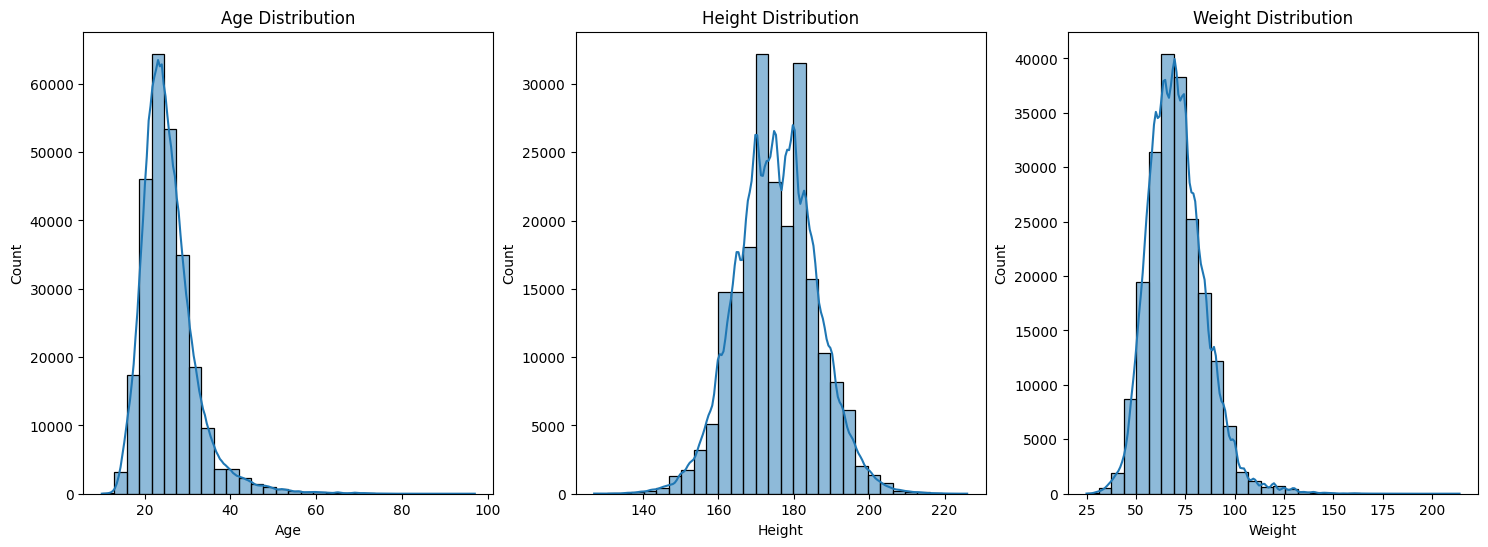

In [278]:
# Data exploration: Analyze distributions of numerical features
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Age distribution
sns.histplot(data['Age'].dropna(), bins=30, kde=True, ax=axs[0])
axs[0].set_title('Age Distribution')

# Height distribution
sns.histplot(data['Height'].dropna(), bins=30, kde=True, ax=axs[1])
axs[1].set_title('Height Distribution')

# Weight distribution
sns.histplot(data['Weight'].dropna(), bins=30, kde=True, ax=axs[2])
axs[2].set_title('Weight Distribution')

plt.show()

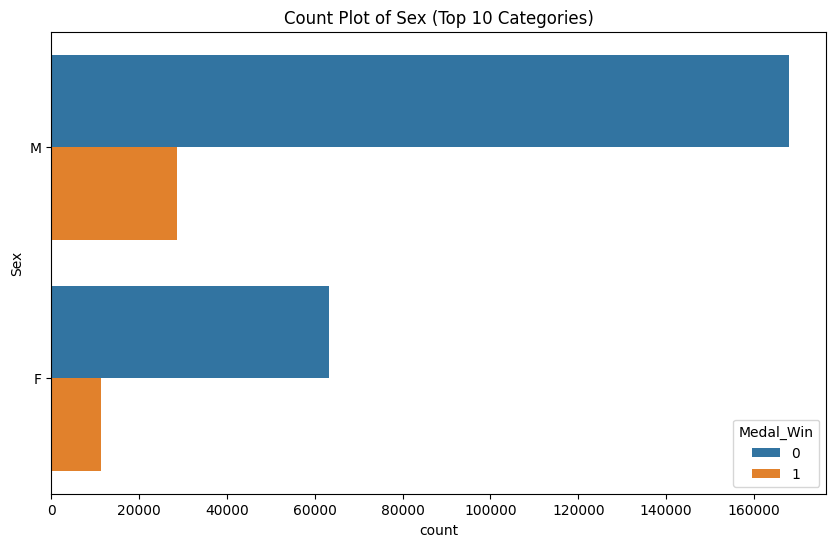

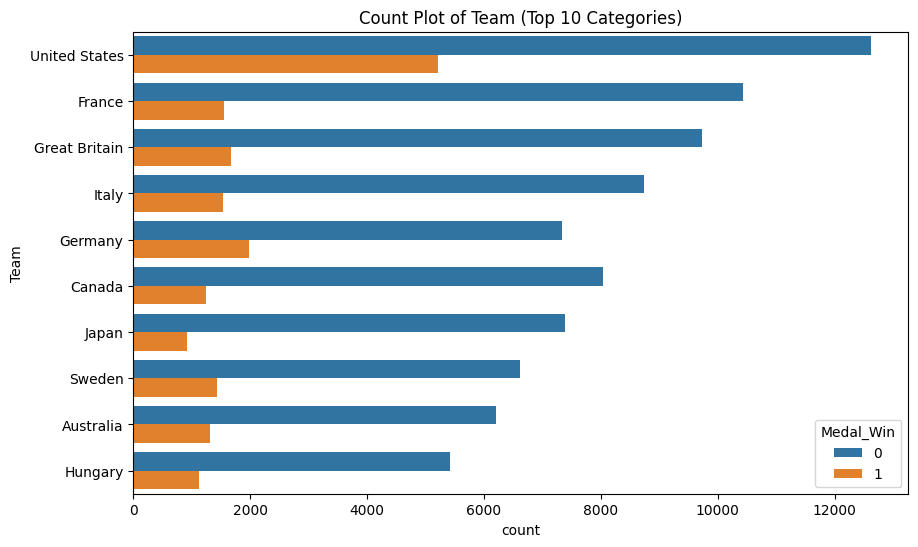

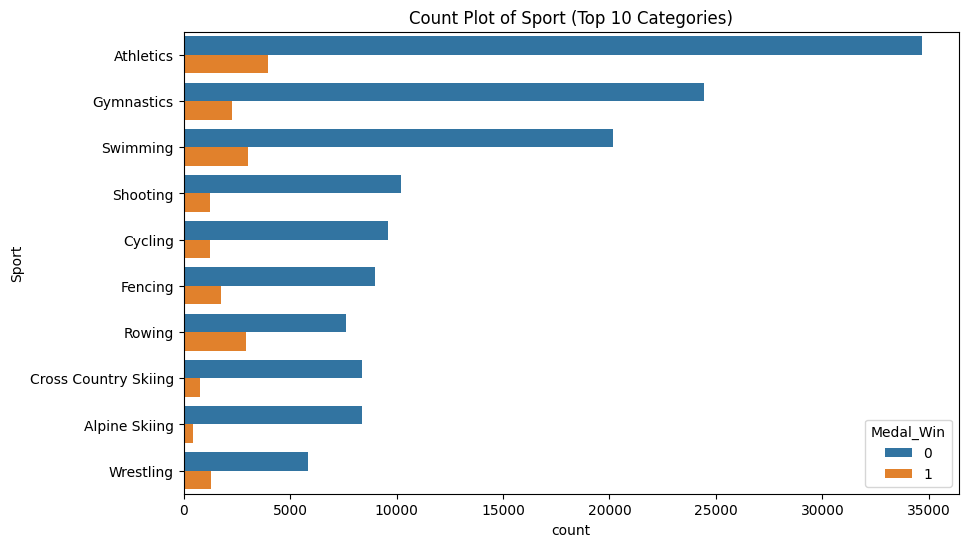

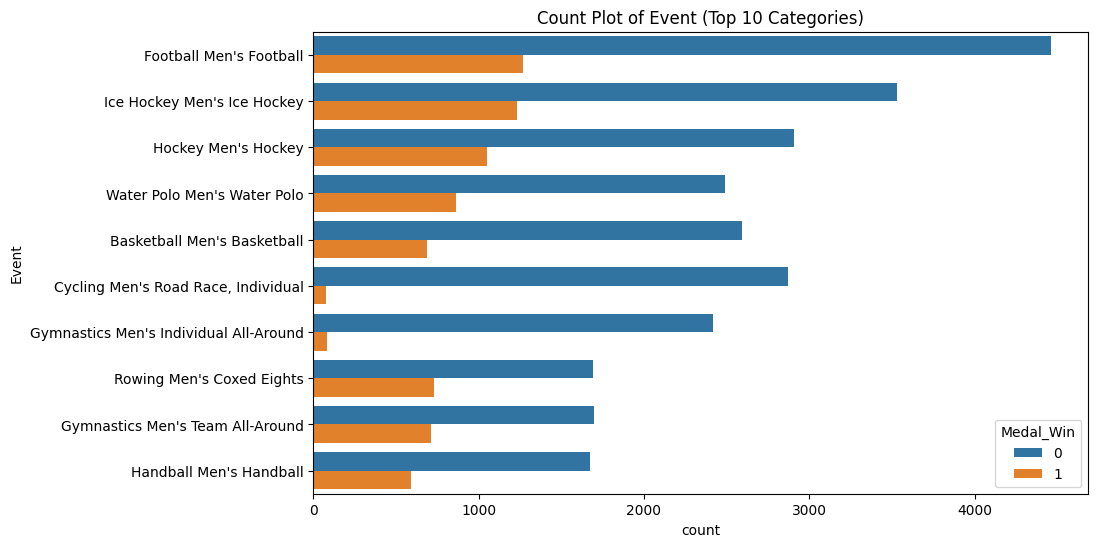

In [265]:
# Count plots for categorical variables with limited categories
def plot_count(df, column, target, limit=10):
    plt.figure(figsize=(10, 6))
    value_counts = df[column].value_counts().nlargest(limit).index
    sns.countplot(y=df[df[column].isin(value_counts)][column], hue=target, data=df, order=value_counts)
    plt.title(f'Count Plot of {column} (Top {limit} Categories)')
    plt.show()

categorical_features = ['Sex', 'Team', 'Sport', 'Event']

for column in categorical_features:
    plot_count(data, column, 'Medal_Win')

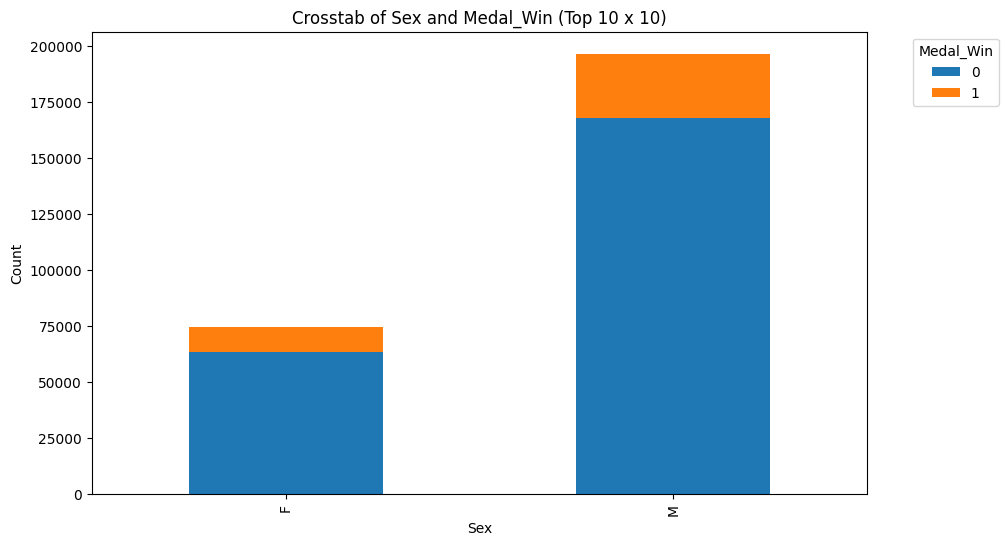

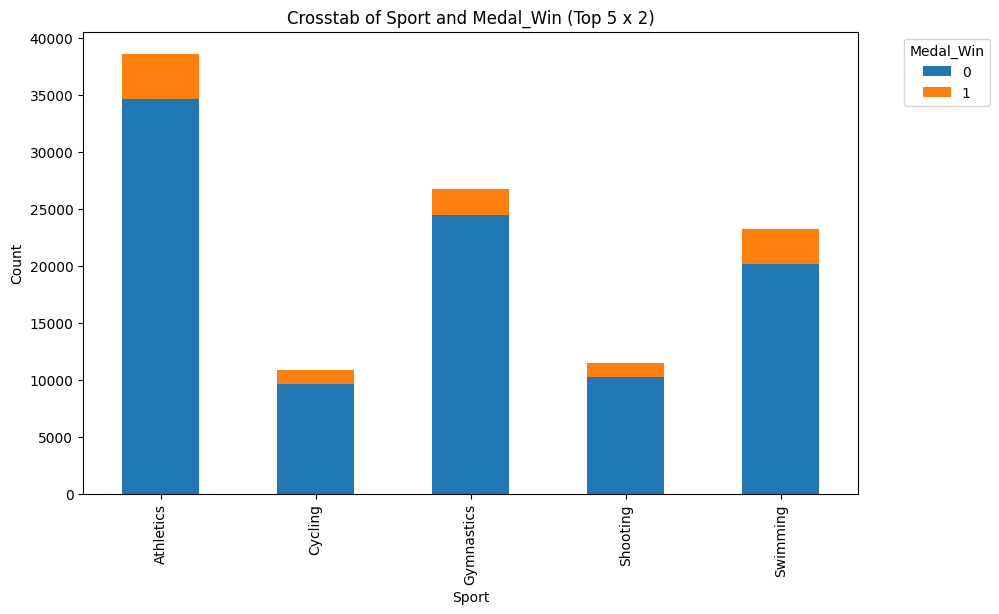

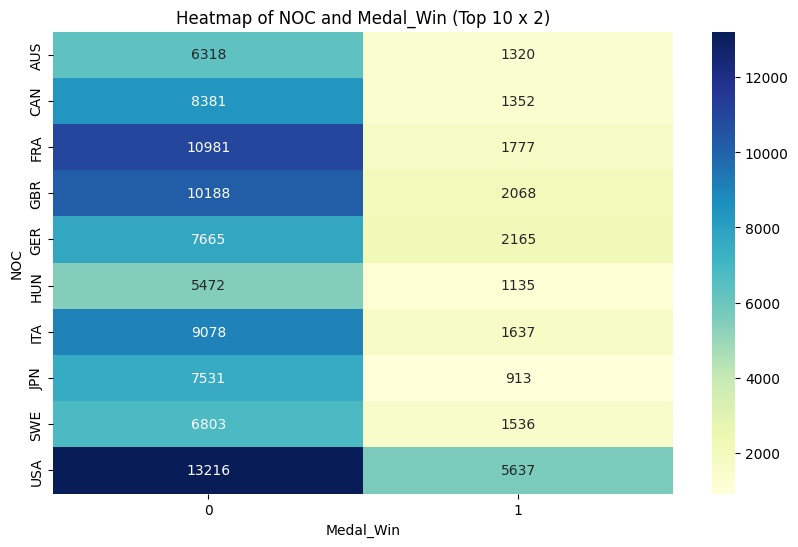

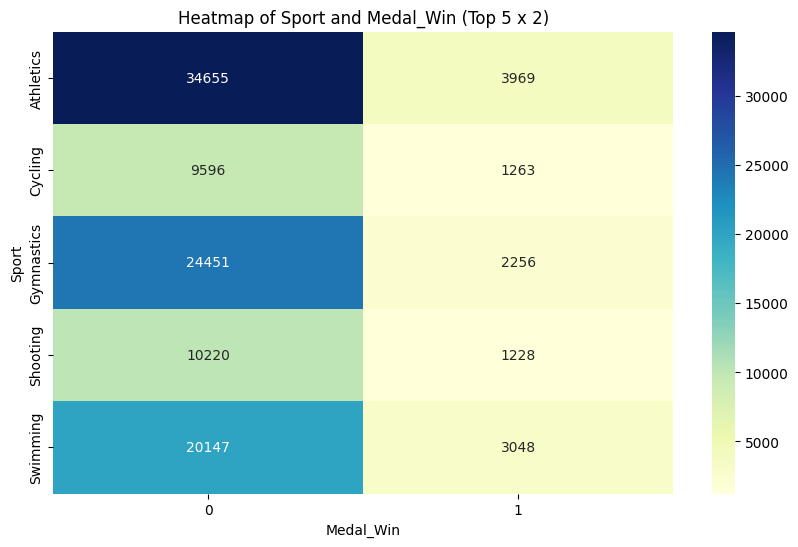

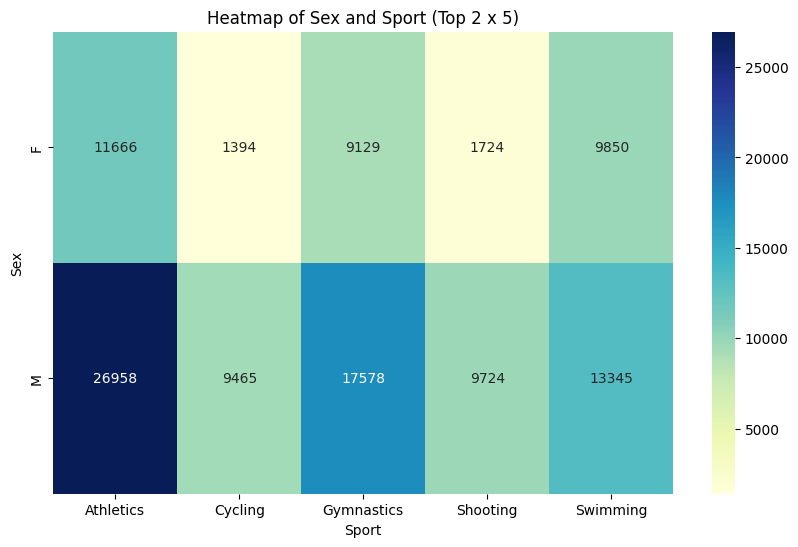

In [266]:
# Cross-tabulations and heatmaps with limited categories
def plot_crosstab(df, column1, column2, limit1=10, limit2=10):
    value_counts1 = df[column1].value_counts().nlargest(limit1).index
    value_counts2 = df[column2].value_counts().nlargest(limit2).index
    crosstab = pd.crosstab(df[df[column1].isin(value_counts1)][column1], df[df[column2].isin(value_counts2)][column2])
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Crosstab of {column1} and {column2} (Top {limit1} x {limit2})')
    plt.xlabel(column1)
    plt.ylabel('Count')
    plt.legend(title=column2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def plot_heatmap(df, column1, column2, limit1=10, limit2=10):
    value_counts1 = df[column1].value_counts().nlargest(limit1).index
    value_counts2 = df[column2].value_counts().nlargest(limit2).index
    crosstab = pd.crosstab(df[df[column1].isin(value_counts1)][column1], df[df[column2].isin(value_counts2)][column2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f'Heatmap of {column1} and {column2} (Top {limit1} x {limit2})')
    plt.xlabel(column2)
    plt.ylabel(column1)
    plt.show()

plot_crosstab(data, 'Sex', 'Medal_Win')
plot_crosstab(data, 'Sport', 'Medal_Win', limit1=5, limit2=2)
plot_heatmap(data, 'NOC', 'Medal_Win', limit1=10, limit2=2)
plot_heatmap(data, 'Sport', 'Medal_Win', limit1=5, limit2=2)
plot_heatmap(data, 'Sex', 'Sport', limit1=2, limit2=5)

In [267]:
# Handle missing values and encode categorical variables
numeric_features = ['Age', 'Height', 'Weight']
categorical_features = ['Sex', 'Team', 'Sport', 'Event', 'HomeGame']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [269]:
# handle missing values and encoding
numeric_features = ['Age', 'Height', 'Weight']
categorical_features = ['Sex', 'Team', 'Sport', 'Event', 'HomeGame']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [270]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

models = {
    'logistic_regression': LogisticRegression(max_iter=1000),
    'random_forest': RandomForestClassifier(),
    'gradient_boosting': GradientBoostingClassifier(),
    'svm': SVC()
}

param_grids = {
    'logistic_regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    'random_forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    'gradient_boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'svm': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf']
    }
}

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'logistic_regression': LogisticRegression(max_iter=1000),
    'random_forest': RandomForestClassifier()
}

param_grids = {
    'logistic_regression': {
        'classifier__C': [0.01, 0.1, 1]
    },
    'random_forest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10]
    }
}

best_models = {}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    param_grid = param_grids[model_name]
    
    random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=5, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)
    
    best_models[model_name] = random_search.best_estimator_
    
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {random_search.best_score_}")

    y_pred = random_search.predict(X_test)
    print(f"Metrics for {model_name}:\n{classification_report(y_test, y_pred, target_names=['No Medal', 'Medal'])}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for logistic_regression: {'classifier__C': 1}
Best cross-validation score for logistic_regression: 0.8630055501024424
Classification report for logistic_regression:
              precision    recall  f1-score   support

    No Medal       0.87      0.99      0.93     46290
       Medal       0.67      0.15      0.24      7934

    accuracy                           0.87     54224
   macro avg       0.77      0.57      0.59     54224
weighted avg       0.84      0.87      0.83     54224



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for random_forest: {'classifier__n_estimators': 100, 'classifier__max_depth': None}
Best cross-validation score for random_forest: 0.8859340096229994
Classification report for random_forest:
              precision    recall  f1-score   support

    No Medal       0.91      0.96      0.94     46290
       Medal       0.67      0.45      0.54      7934

    accuracy                           0.89     54224
   macro avg       0.79      0.71      0.74     54224
weighted avg       0.88      0.89      0.88     54224



In [275]:
# Making predictions using random forest and logistic regression
y_pred_logistic = best_models['logistic_regression'].predict(X_test)
y_pred_random_forest = best_models['random_forest'].predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic, target_names=['No Medal', 'Medal']))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_random_forest, target_names=['No Medal', 'Medal']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    No Medal       0.87      0.99      0.93     46290
       Medal       0.67      0.15      0.24      7934

    accuracy                           0.87     54224
   macro avg       0.77      0.57      0.59     54224
weighted avg       0.84      0.87      0.83     54224

Random Forest Classification Report:
              precision    recall  f1-score   support

    No Medal       0.91      0.96      0.94     46290
       Medal       0.67      0.45      0.54      7934

    accuracy                           0.89     54224
   macro avg       0.79      0.71      0.74     54224
weighted avg       0.88      0.89      0.88     54224

